# Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else. In ths notebook segmentation of the Whole tumor (WT) subregion is carried out.

Feel free to drop your suggestions at: sourjyamukherjee261@gmail.com



![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Setup env

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}


VOLUME_SLICES = 100
VOLUME_START_AT = 25 # first slice of volume that we will include

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

Text(0.5, 1.0, 'Enhancing_tumor')

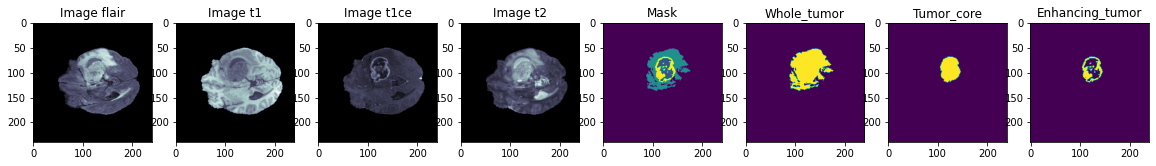

In [4]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8, figsize = (20, 20))
slice_w = 56
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'bone')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'bone')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'bone')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'bone')
ax4.set_title('Image t2')



wt = test_mask.copy()
wt[wt != 0]=1

et = test_mask.copy()
et[et!=4]=0
et[et!=0]=1

tc = test_mask.copy()
tc[tc == 3]=1
tc[tc != 1]=0
tc = tc + et

ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

ax6.imshow(wt[:,:,test_mask.shape[0]//2-slice_w])
ax6.set_title('Whole_tumor')
ax7.imshow(tc[:,:,test_mask.shape[0]//2-slice_w])
ax7.set_title('Tumor_core')
ax8.imshow(et[:,:,test_mask.shape[0]//2-slice_w])
ax8.set_title('Enhancing_tumor')

In [5]:
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize = (2,2))
    img = clahe.apply(img)
    return img

Text(0.5, 1.0, 'Enhancing_tumor')

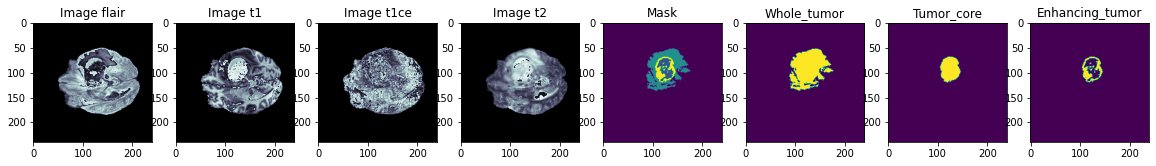

In [36]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8, figsize = (20, 20))
slice_w = 56
ax1.imshow(CLAHE(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w].astype(np.uint8)), cmap = 'bone')
ax1.set_title('Image flair')
ax2.imshow(CLAHE(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w].astype(np.uint8)), cmap = 'bone')
ax2.set_title('Image t1')
ax3.imshow(CLAHE(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w].astype(np.uint8)), cmap = 'bone')
ax3.set_title('Image t1ce')
ax4.imshow(CLAHE(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w].astype(np.uint8)), cmap = 'bone')
ax4.set_title('Image t2')



wt = test_mask.copy()
wt[wt != 0]=1

et = test_mask.copy()
et[et!=4]=0
et[et!=0]=1

tc = test_mask.copy()
tc[tc == 3]=1
tc[tc != 1]=0
tc = tc + et

ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

ax6.imshow(wt[:,:,test_mask.shape[0]//2-slice_w])
ax6.set_title('Whole_tumor')
ax7.imshow(tc[:,:,test_mask.shape[0]//2-slice_w])
ax7.set_title('Tumor_core')
ax8.imshow(et[:,:,test_mask.shape[0]//2-slice_w])
ax8.set_title('Enhancing_tumor')

**CLAHE is not helping will go ahead with the original slices**

Exploring the saggital slices

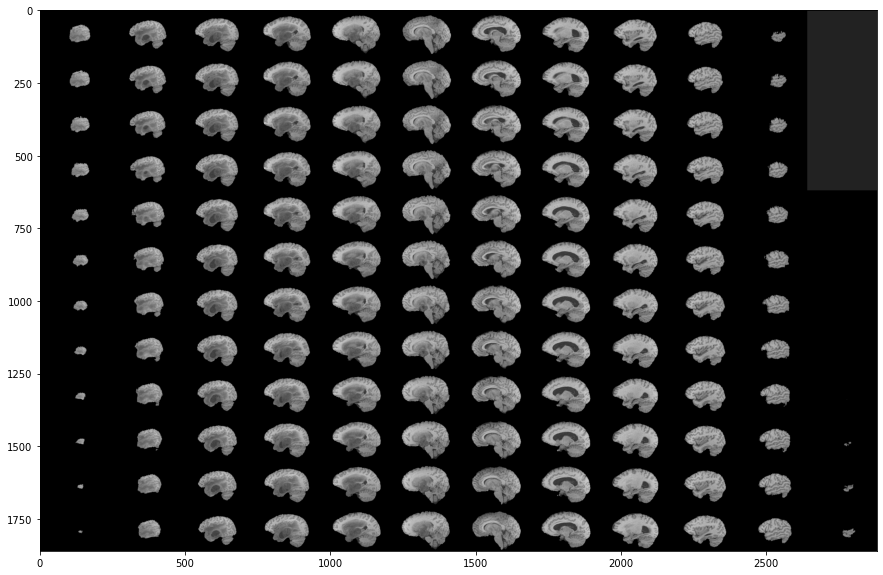

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

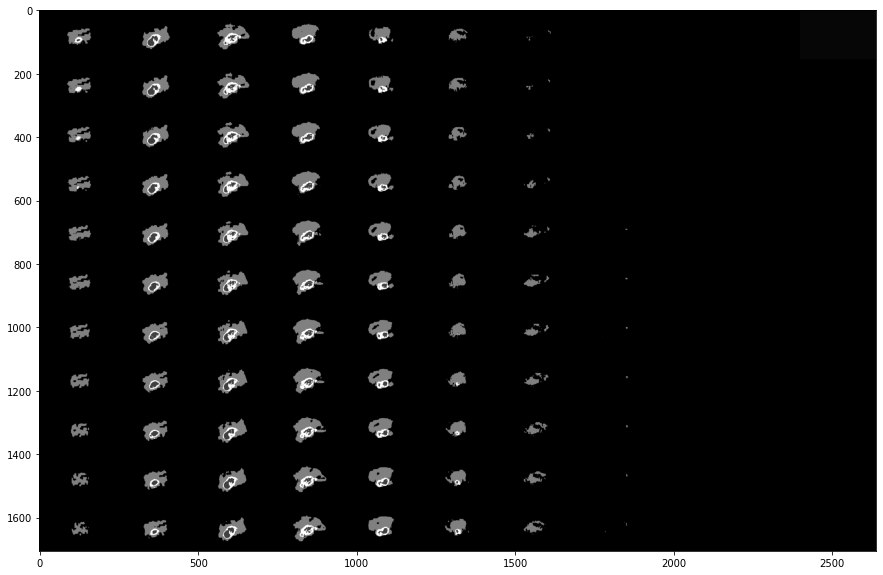

In [7]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

**Show segments of tumor using different effects**

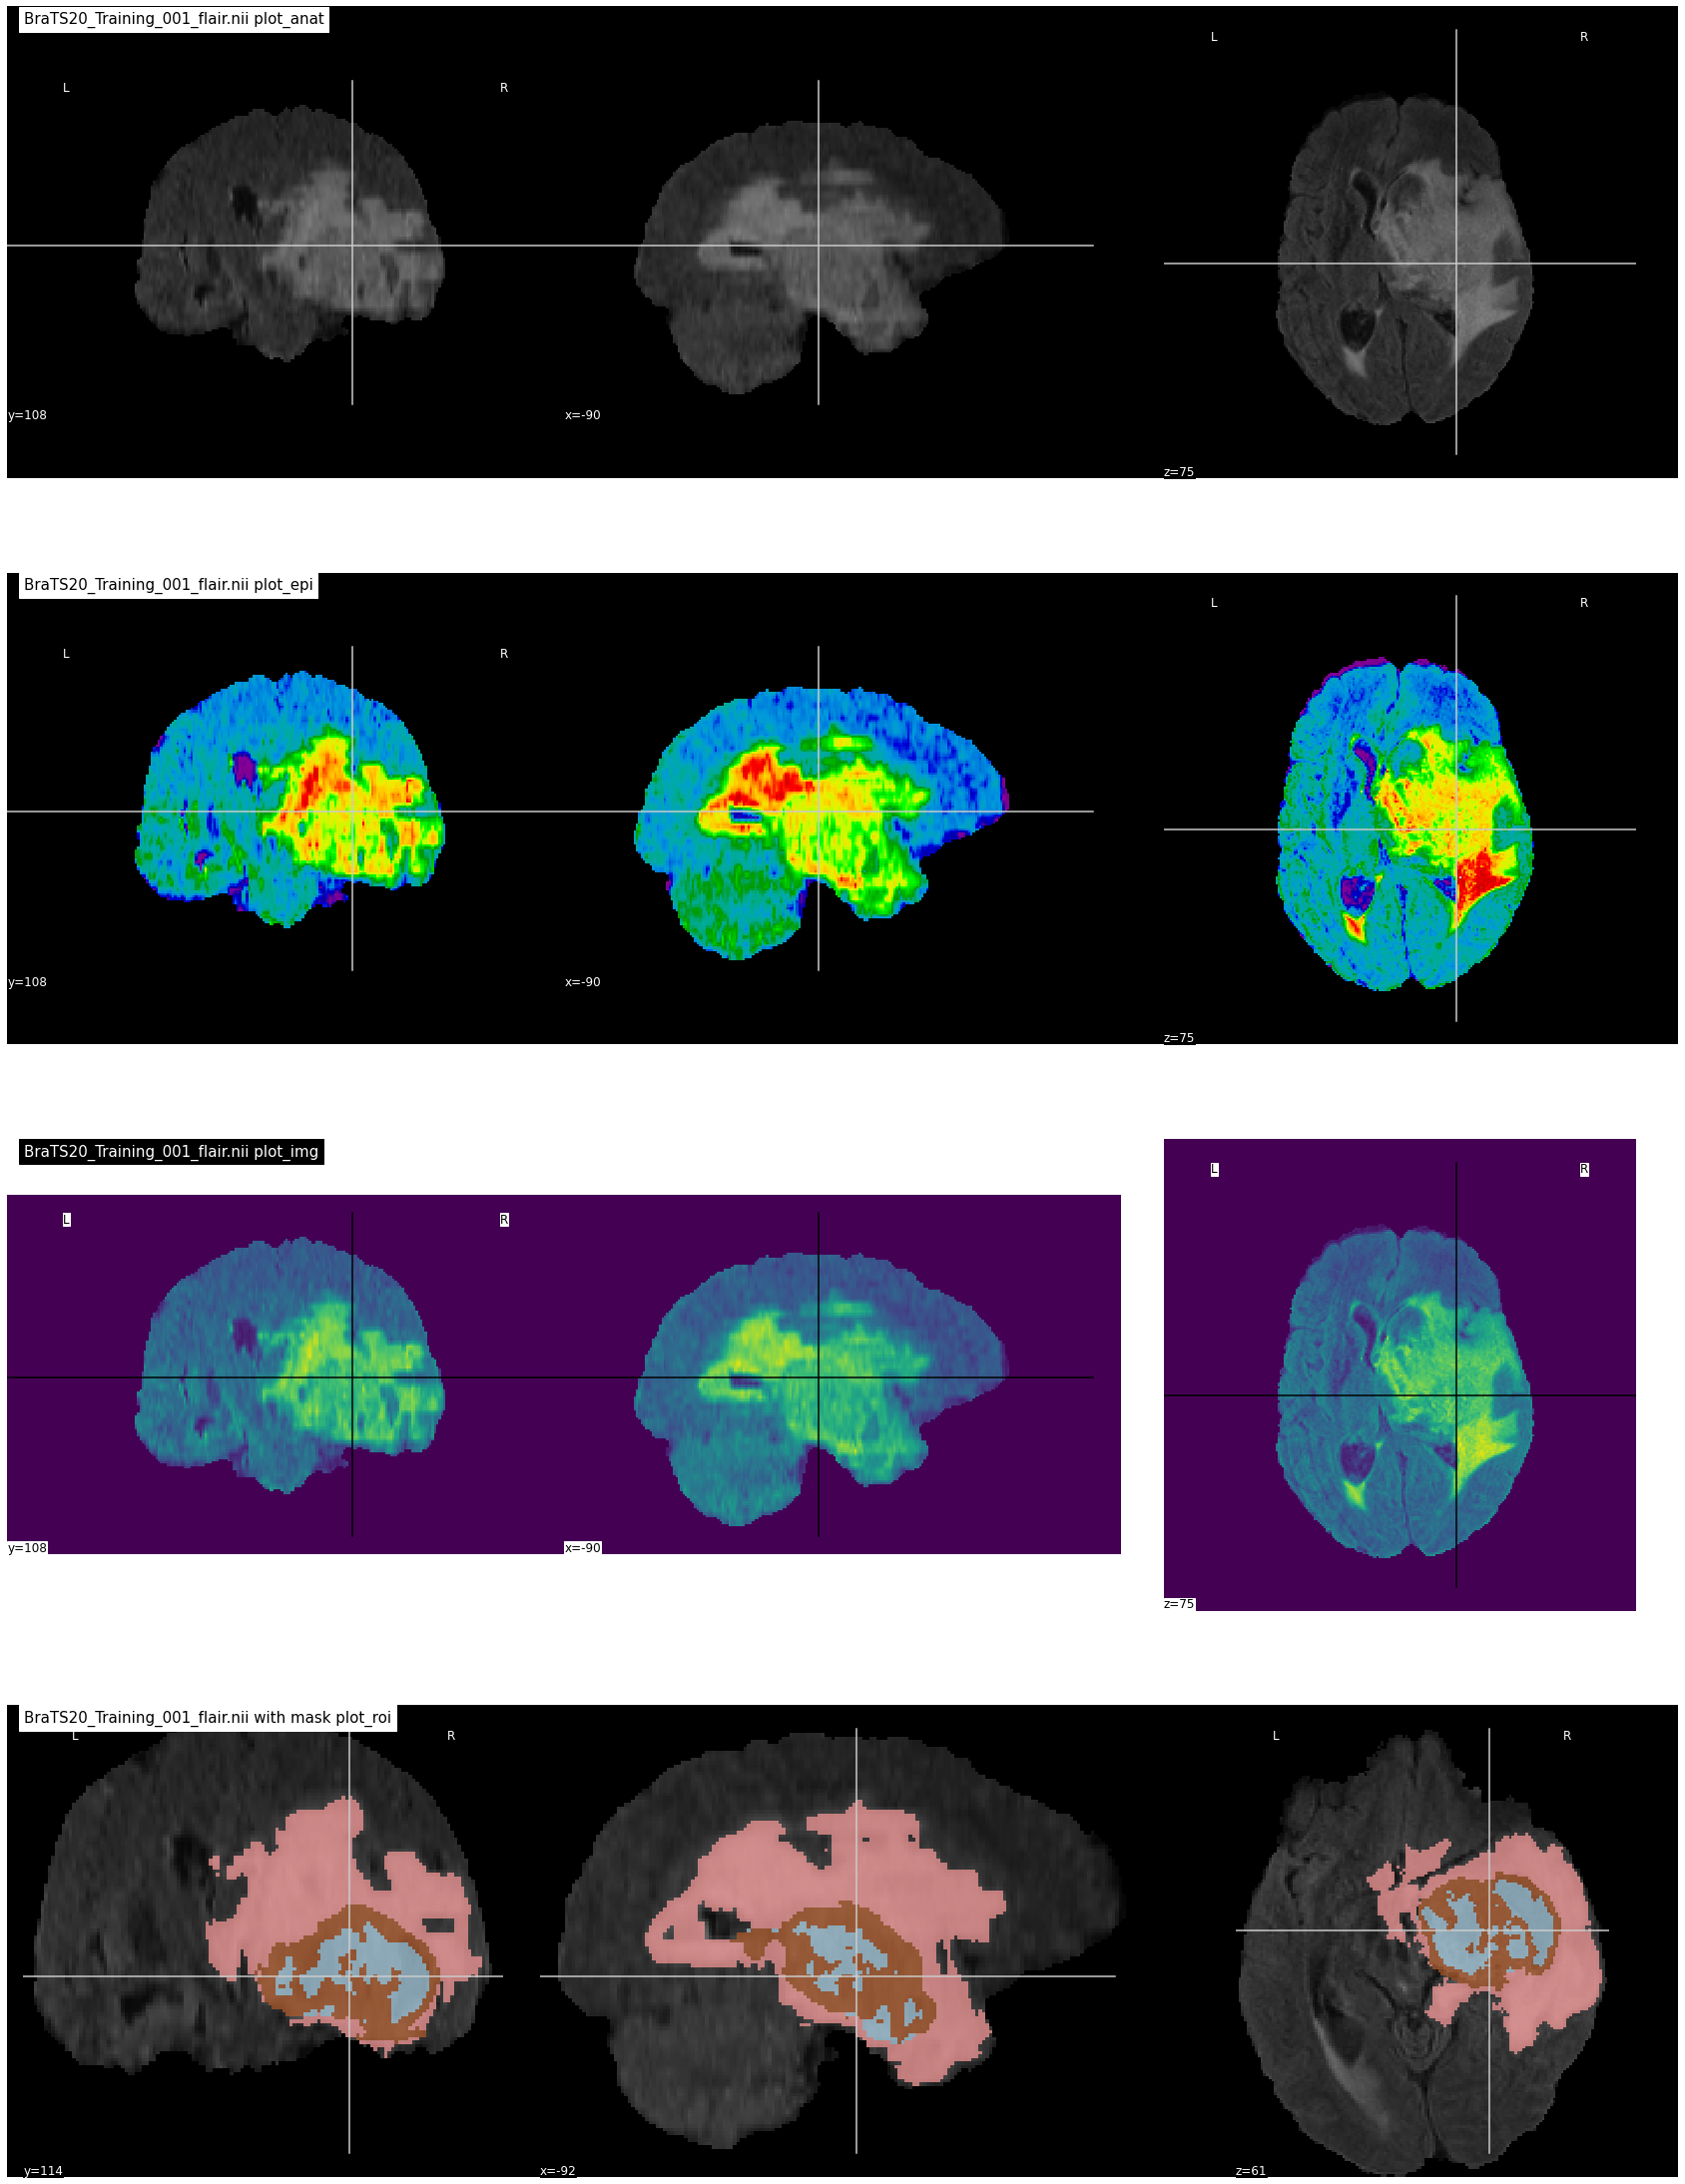

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

**Defining Loss Functions and some Metrics**

In [4]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_wt(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)
"""
def dice_loss(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = (1-loss)
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def tversky(y_true, y_pred):
    smooth=1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def total_loss(y_true,y_pred):
    return focal_tversky(y_true,y_pred) + dice_loss(y_true,y_pred)
"""

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def tversky(y_true, y_pred):
    smooth=1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

In [5]:
!pip install -U segmentation-models
#%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
wt0, wt1 = 0.50,0.50
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [8]:
IMG_SIZE=128

In [7]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    #x = squeeze_excite_block(x,8)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    x = squeeze_excite_block(x)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)

    """ Encoder 1 """
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(32, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    c1 = squeeze_excite_block(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = residual_block(c1,32)

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, 64)
    c2 = squeeze_excite_block(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = residual_block(c2,64)
    
    c3 = residual_block(p2, 128)
    c3 = squeeze_excite_block(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = residual_block(c3,128)

    c4 = residual_block(p3, 256)
    c4 = squeeze_excite_block(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = residual_block(c4,256)

    """ Bridge """
    b = ASPP(p4,128)

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    """ Classifier """
    outputs = Conv2D(2, (1,1) , activation="softmax")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

model = build_resunet((IMG_SIZE,IMG_SIZE,3))
model.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_wt,sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )

2023-01-10 20:21:11.062096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:21:11.168192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:21:11.169336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:21:11.171756: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [9]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

for i in train_and_test_ids:
    
    case_path = os.path.join(TRAIN_DATASET_PATH,i)
    data_path = os.path.join(case_path, f'{i}_seg.nii');
    seg = nib.load(data_path).get_fdata()
    seg = seg[56:184,56:184,:]
    
    count = 0
    for j in range(VOLUME_SLICES):

                 temp_mask = seg[:,:,j+VOLUME_START_AT];
                 val, counts = np.unique(temp_mask, return_counts=True)
    
                 if (1 - (counts[0]/counts.sum())) > 0.01:
                     count = count + 1
    if (count==0):
        train_and_test_ids.remove(i)
        print(i)
        
    

In [11]:
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2,random_state=42) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15,random_state=42) 

In [15]:
for i in range (5):
    print(train_ids[i])

BraTS20_Training_272
BraTS20_Training_113
BraTS20_Training_257
BraTS20_Training_040
BraTS20_Training_015


In [17]:
for i in range (5):
    print(test_ids[i])

BraTS20_Training_246
BraTS20_Training_357
BraTS20_Training_242
BraTS20_Training_263
BraTS20_Training_214


**Override Keras sequence DataGenerator class**

In [12]:
scaler = MinMaxScaler()

In [13]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 1))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()
            shape = flair.shape
            flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(shape)
            flair = flair[56:184,56:184,:]

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            shape = ce.shape
            ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(shape)
            ce = ce[56:184,56:184,:]
            
            
            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()
            shape = t2.shape
            t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(shape)
            t2 = t2[56:184,56:184,:]
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
            seg = seg[56:184,56:184,:]

        
            
        
            for j in range(VOLUME_SLICES):
                    #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    temp_mask = seg[:,:,j+VOLUME_START_AT]
                    temp_mask[temp_mask != 0]=1
                    #y[j +VOLUME_SLICES*c] = (np.expand_dims(temp_mask,axis=-1))
                    y[j +VOLUME_SLICES*c] = temp_mask
                    X[j +VOLUME_SLICES*c,:,:,0] = flair[:,:,j+VOLUME_START_AT]
                    X[j +VOLUME_SLICES*c,:,:,1] = ce[:,:,j+VOLUME_START_AT]
                    X[j +VOLUME_SLICES*c,:,:,2] = t2[:,:,j+VOLUME_START_AT]
                    
                    
                    
        # Generate masks
        y = tf.one_hot(y, 2)

        """
        print(X.shape)
        print(y.shape)
        print(np.unique(y))
        """

        return X, y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

In [8]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))


249
74
45


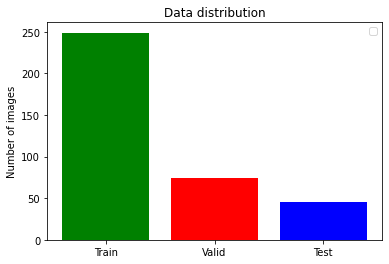

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [15]:
csv_logger = CSVLogger('./training.log', separator=',', append=False)


callbacks = [
      #keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
      #                         patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = './model_wt.h5',
                              verbose=1, save_best_only=True),
      csv_logger
    ]

# Train model
I dont uderstand why binary segmentation did not wok here. I had to convert the masks into categorical even for this task.

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("./model_wt_final.h5")

**Visualize the training process**

In [16]:
############ load trained model ################
model = keras.models.load_model('/kaggle/input/model-and-log/model_wt_final.h5', 
                                   custom_objects={ 'IoU' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "tversky": tversky,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_wt": dice_coef_wt,
                                                   "auc": tf.keras.metrics.AUC(),
                                                   
                                                  }, compile=False)

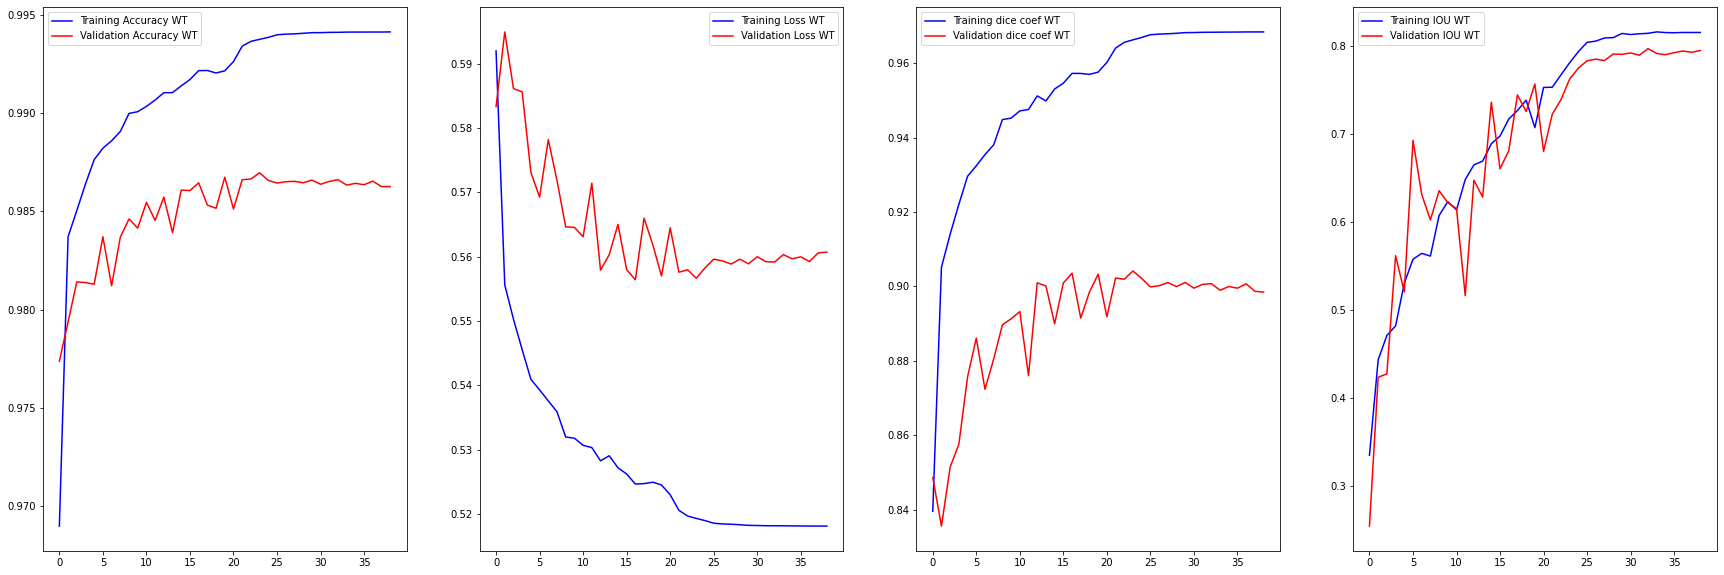

In [4]:
history = pd.read_csv('/kaggle/input/model-and-log/training_log_wt.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(30,10))

ax[0].plot(epoch,acc,'b',label='Training Accuracy WT')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy WT')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss WT')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss WT')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef WT')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef WT')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training IOU WT')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation IOU WT')
ax[3].legend()

plt.show()

# Prediction examples 

In [17]:

def imageLoader(path):
    image = nib.load(path).get_fdata()
    return np.array(image)



def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[56:184,56:184,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[56:184,56:184,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 [==============================] - 0s 55ms/step


<Figure size 2160x2160 with 0 Axes>

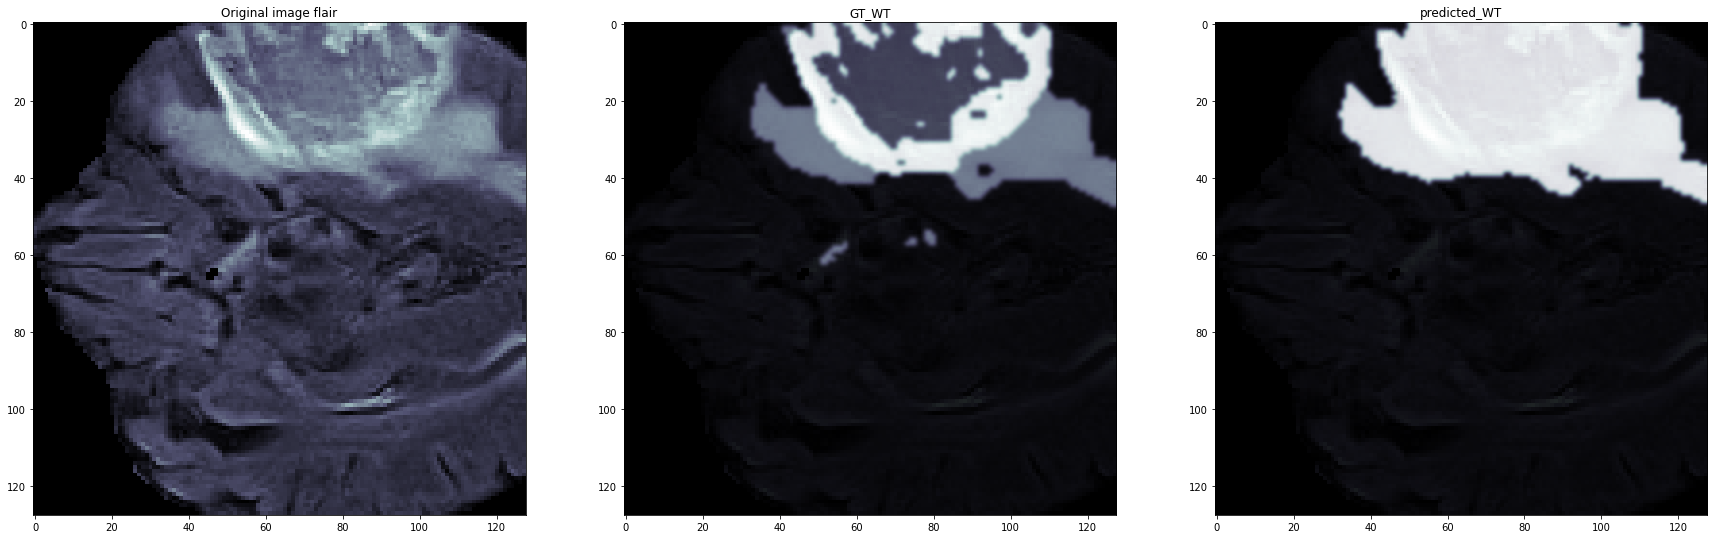

4/4 [==============================] - 0s 50ms/step


<Figure size 2160x2160 with 0 Axes>

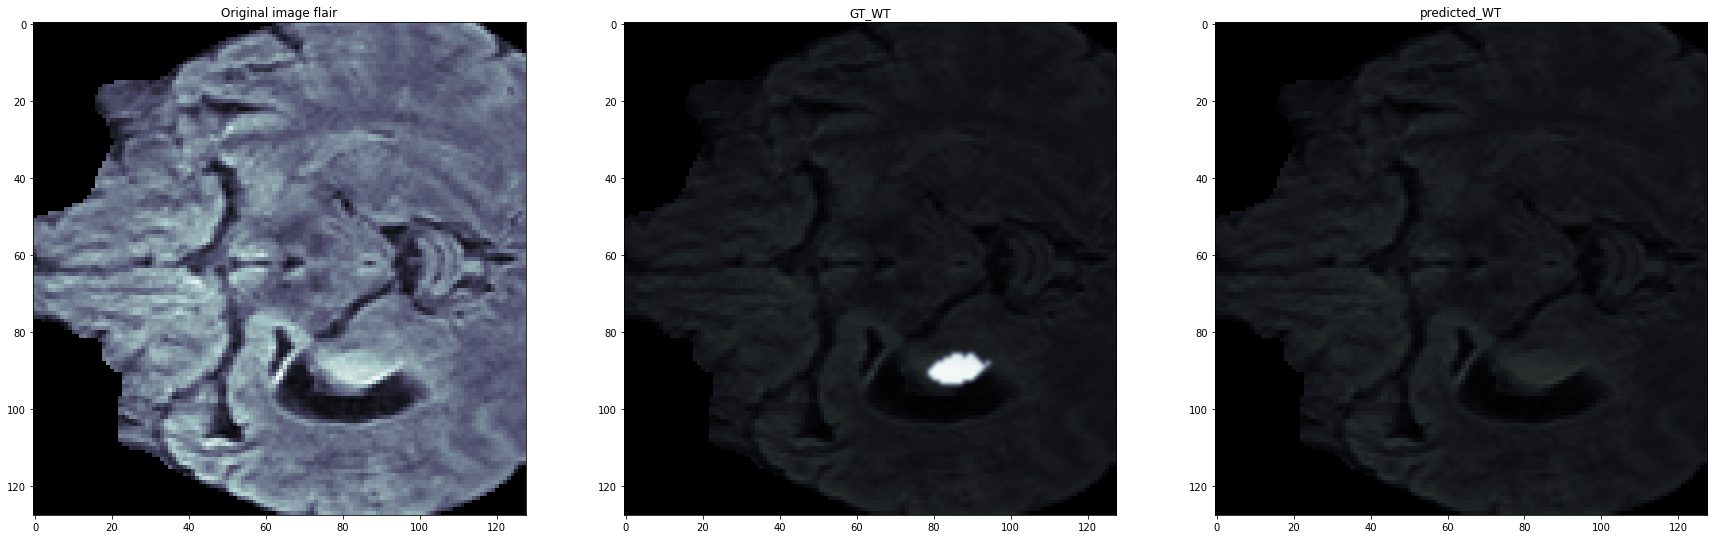

4/4 [==============================] - 0s 41ms/step


<Figure size 2160x2160 with 0 Axes>

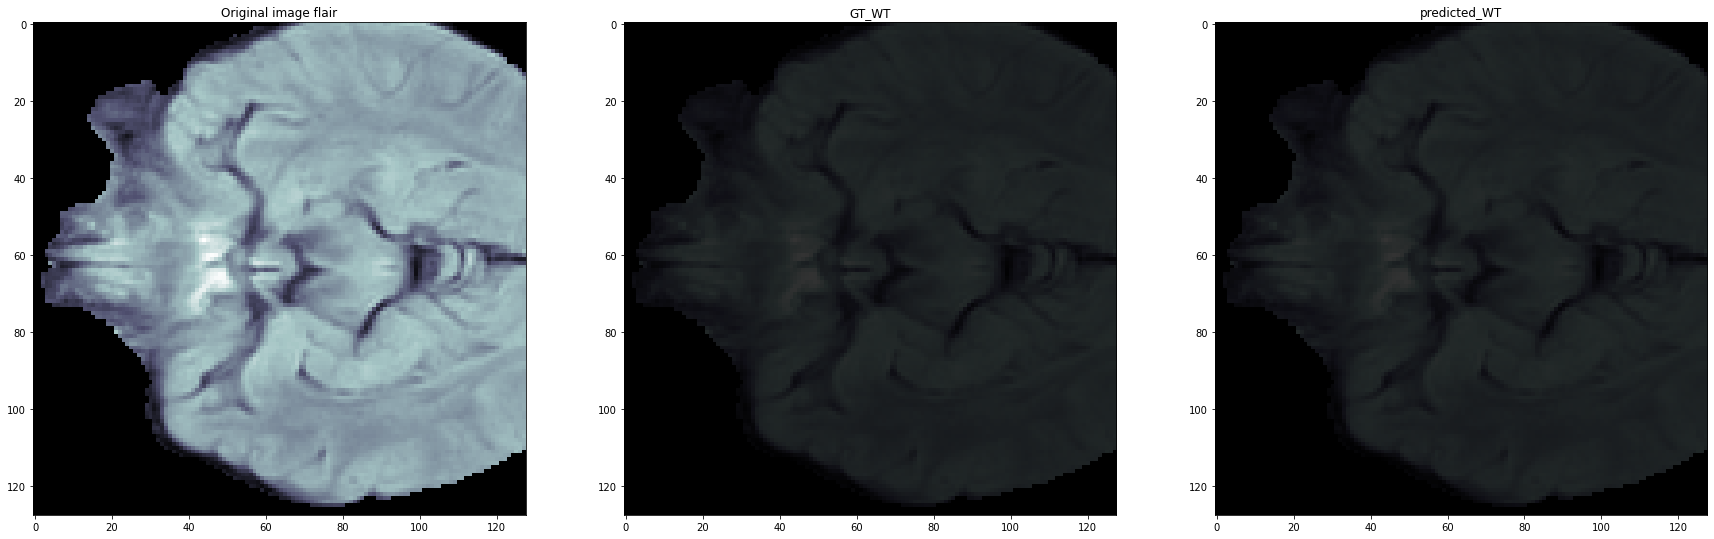

4/4 [==============================] - 0s 41ms/step


<Figure size 2160x2160 with 0 Axes>

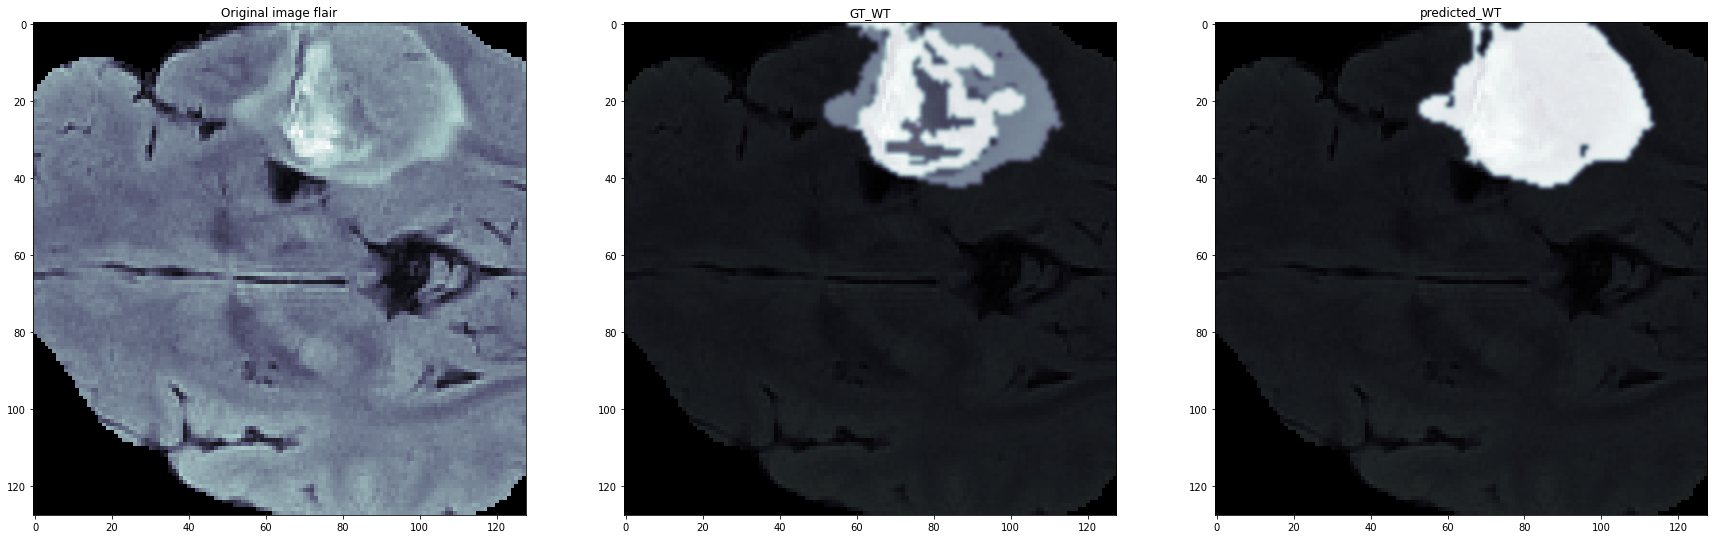

4/4 [==============================] - 0s 41ms/step


<Figure size 2160x2160 with 0 Axes>

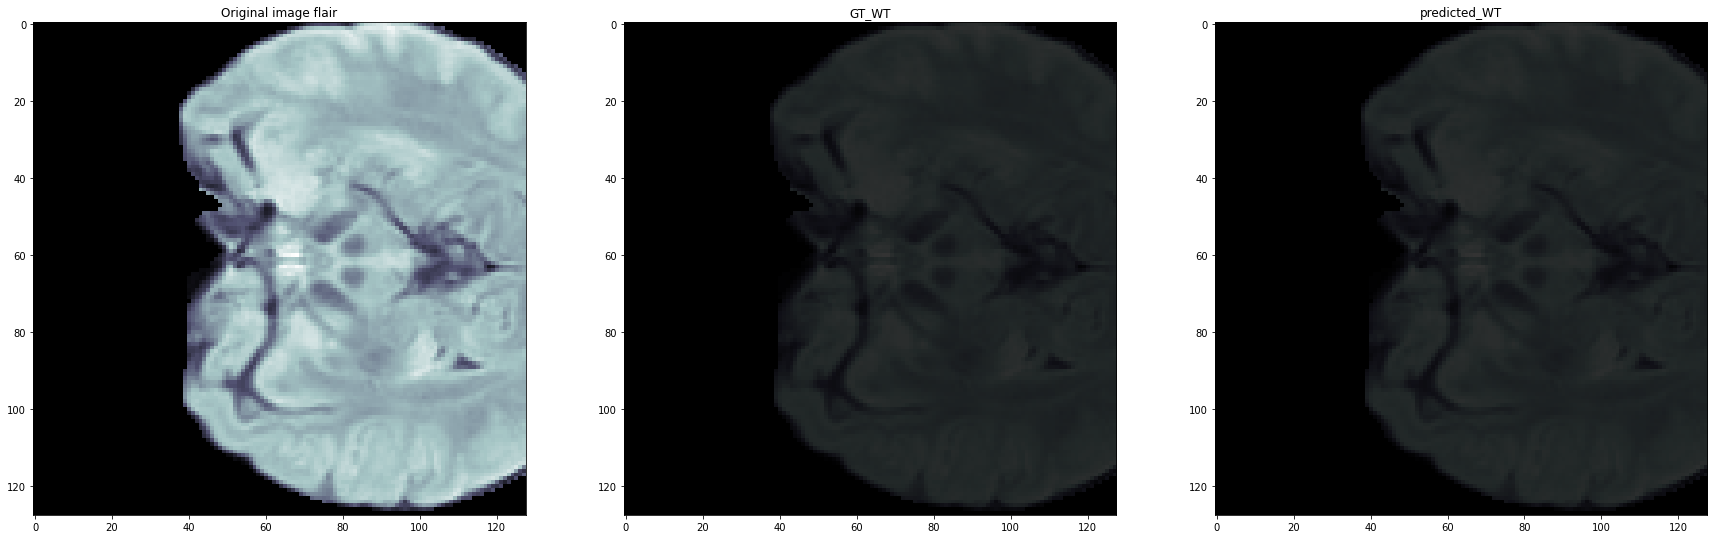

In [19]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    shape = flair.shape
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(shape)
    flair = flair[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    shape = ce.shape
    ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(shape)
    ce = ce[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii');
    t2=nib.load(vol_path).get_fdata() 
    shape = t2.shape
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(shape)
    t2 = t2[56:184,56:184,:]
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = flair[:,:,j+VOLUME_START_AT]
        X[j,:,:,1] = ce[:,:,j+VOLUME_START_AT]
        X[j,:,:,2] = t2[:,:,j+VOLUME_START_AT]
        
        
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X,verbose=1)


def showPredictsById(case, start_slice = 35):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

   
    wt = gt.copy()
    wt[wt != 0]=1
    
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)
    p = p>0.5

    tumor_core= p[:,:,:,1]
    cmap = 'bone'
    a = 0.8
    inter = 'bicubic'

    plt.figure(figsize=(30,30))
    f, axarr = plt.subplots(1,3, figsize = (30,30)) 

    for i in range(3): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(gt[56:184,56:184,start_slice+VOLUME_START_AT] , interpolation= inter,cmap = 'bone', alpha=a)
    axarr[1].title.set_text('GT_WT')
    axarr[2].imshow(p[start_slice,:,:,1], interpolation=inter,cmap = cmap, alpha=a)
    axarr[2].title.set_text('predicted_WT')
    plt.show()
    
for i in range (5,10):    
    showPredictsById(case=test_ids[i][-3:])


# Evaluation

4/4 [==============================] - 0s 43ms/step


<Figure size 432x288 with 0 Axes>

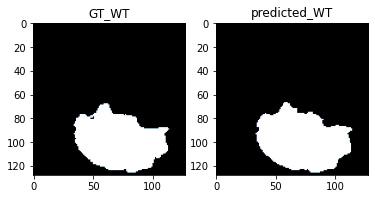

In [26]:
case = case=test_ids[11][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

wt = gt.copy()
wt[wt != 0]=1

p = predictByPath(path,case)
p = p>0.5

tumor_core = p[:,:,:,1]


i=35 # slice at
#eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



#gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = wt[56:184,56:184,i+VOLUME_START_AT]

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="bone")
axarr[0].title.set_text('GT_WT')
axarr[1].imshow(p[i,:,:,1], cmap="bone")
axarr[1].title.set_text('predicted_WT')
plt.show()

In [45]:
model.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef_wt, sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 37s 758ms/step - loss: 0.5470 - accuracy: 0.9889 - mean_io_u_7: 0.7178 - dice_coef_wt: 0.9194 - sensitivity: 0.9889 - specificity: 0.9889 - tversky: 0.9884 - auc_6: 0.9956
test loss, test acc: [0.5470057725906372, 0.9889259934425354, 0.7178225517272949, 0.9193703532218933, 0.9889258742332458, 0.9889258742332458, 0.9883668422698975, 0.995611310005188]


In [20]:
model_wt = keras.models.load_model('/kaggle/input/model-and-log/model_wt_final.h5', 
                                   custom_objects={ 'IoU' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef_wt": dice_coef_wt,
                                                   "tversky": tversky,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_wt": dice_coef_wt,
                                                   "auc": tf.keras.metrics.AUC(),
                                                   
                                                  }, compile=False)
model_tc = build_resunet((IMG_SIZE,IMG_SIZE,3))
model_tc.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_wt,sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )
model_tc.load_weights('/kaggle/input/tc-and-et-models/model_tc.h5')

model_et = build_resunet((IMG_SIZE,IMG_SIZE,3))
model_et.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_wt,sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )
model_et.load_weights('/kaggle/input/tc-and-et-models/model_et.h5')

4/4 [==============================] - 0s 41ms/step
363


<Figure size 2160x2160 with 0 Axes>

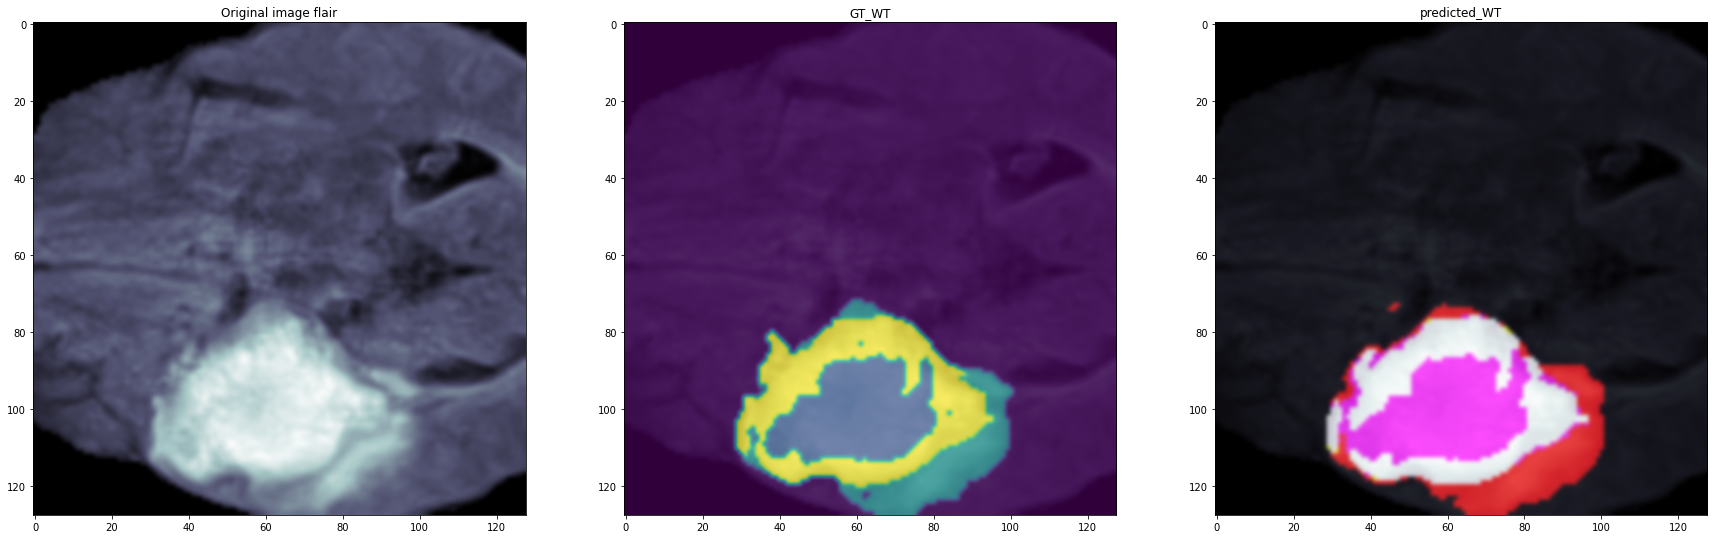

In [42]:
def predictByPath(case_path,case,CLASS):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    shape = flair.shape
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(shape)
    flair = flair[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    shape = ce.shape
    ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(shape)
    ce = ce[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii');
    t2=nib.load(vol_path).get_fdata() 
    shape = t2.shape
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(shape)
    t2 = t2[56:184,56:184,:]
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    if CLASS == 'ET':
        for j in range(VOLUME_SLICES):
            X[j,:,:,0] = flair[:,:,j+VOLUME_START_AT]
            X[j,:,:,1] = ce[:,:,j+VOLUME_START_AT]
            X[j,:,:,2] = t2[:,:,j+VOLUME_START_AT]
        return model_et.predict(X,verbose=1)
    
    if CLASS == 'TC':
        for j in range(VOLUME_SLICES):
            X[j,:,:,0] = ce[:,:,j+VOLUME_START_AT]
            X[j,:,:,1] = flair[:,:,j+VOLUME_START_AT]
            X[j,:,:,2] = t2[:,:,j+VOLUME_START_AT]
        
        return model_tc.predict(X,verbose=1)
    if CLASS == 'WT':
        for j in range(VOLUME_SLICES):
            X[j,:,:,0] = flair[:,:,j+VOLUME_START_AT]
            X[j,:,:,1] = ce[:,:,j+VOLUME_START_AT]
            X[j,:,:,2] = t2[:,:,j+VOLUME_START_AT]
        
        return model_wt.predict(X,verbose=1)


def showPredictsById(case, start_slice = 45):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

   
    wt = gt.copy()
    wt[wt != 0]=1
    
    et = gt.copy()
    et[et!=4]=0
    et[et!=0]=1

    tc = gt.copy()
    tc[tc == 3]=1
    tc[tc != 1]=0
    tc = tc + et

    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p_wt = predictByPath(path,case,'WT')
    p_et = predictByPath(path,case,'ET')
    p_tc = predictByPath(path,case,'TC')
    p_wt = p_wt+p_et+p_tc
    p_tc = p_tc + p_et
    p_wt = p_wt>0.5
    p_wt[p_wt!=0]=1
    p_et = p_et>0.3
    p_et[p_et!=0]=1
    p_tc = p_tc>0.5
    p_tc[p_tc!=0]=1
    
    p = np.zeros((100,128,128,4))
    p[:,:,:,1]=p_wt[:,:,:,1]
    p[:,:,:,2]=p_et[:,:,:,1]
    p[:,:,:,3]=p_tc[:,:,:,1]

    cmap = 'bone'
    a = 0.7
    inter = 'bicubic'

    plt.figure(figsize=(30,30))
    f, axarr = plt.subplots(1,3, figsize = (30,30)) 

    for i in range(3): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone", interpolation=inter)
    print(case)
    axarr[0].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone",interpolation=inter)
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(gt[56:184,56:184,start_slice+VOLUME_START_AT] , interpolation= inter, alpha=a)
    axarr[1].title.set_text('GT_WT')
    axarr[2].imshow(p[start_slice,:,:,1:4], interpolation=inter, alpha=a)
    axarr[2].title.set_text('predicted_WT')
    plt.show()
    
import random
i = random.randint(0,len(test_ids))
showPredictsById(case=test_ids[i][-3:])
